In [1]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
!pip install tensorflow 


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()


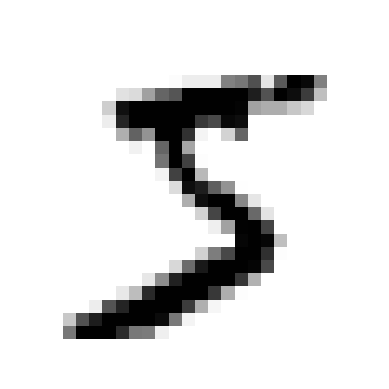

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
some_digit = X_train[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


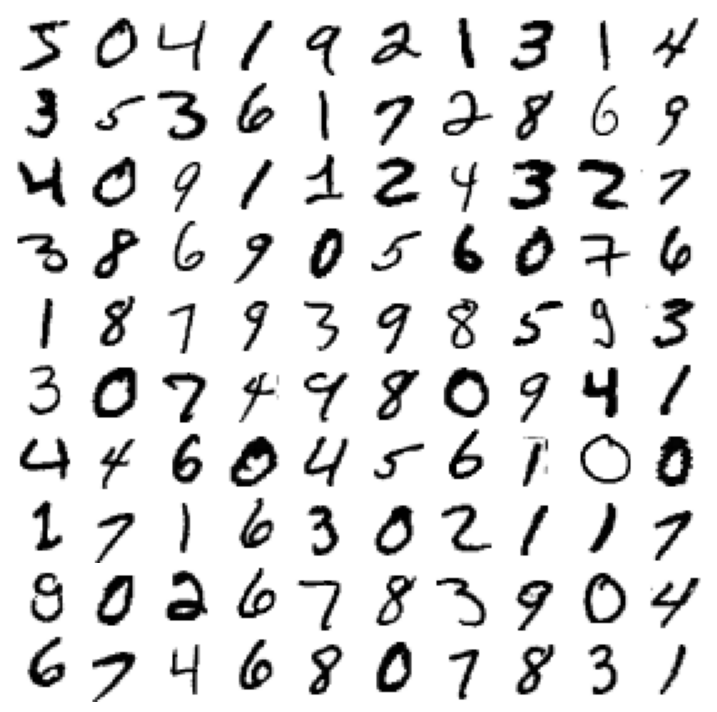

In [6]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X_train[:100]):
    plt.subplot(10, 10, idx + 1)
    plt.imshow(image_data.reshape(28, 28), cmap="binary")
    plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [7]:
y_train[0]

np.uint8(5)

In [8]:
y_train.shape

(60000,)

## Training a binary classifier

In [9]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [10]:
#Treinando um classificador binário
from sklearn.linear_model import SGDClassifier
import numpy as np

# Supõe-se que x_train e y_train_5 já estão carregados corretamente
# Ajuste a forma dos dados de entrada
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # (n_samples, 784)

# Inicialize e treine o modelo
sgd_clf = SGDClassifier(random_state=42)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
sgd_clf.fit(X_train_flattened, y_train_5)


SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit.flatten()])

array([ True])

## Performance Measures

Measuring accuracy using cross-validation

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_flattened, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    X_train_folds = X_train_flattened[train_index]
    X_test_fold = X_train_flattened[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [14]:
from sklearn.dummy import DummyClassifier

# Cria uma instância do DummyClassifier com estratégia de prever sempre a classe mais frequente
dummy_clf = DummyClassifier(strategy="most_frequent")

# Treina o DummyClassifier usando o conjunto de treinamento
dummy_clf.fit(X_train, y_train_5)

# Faz previsões no mesmo formato do conjunto de treinamento
y_pred = dummy_clf.predict(X_train)


## Confusion Matrix
-> Ideia de contabilizar quantas vezes as instancias da classe A sao classificados como classe B.

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_flattened, y_train_5, cv=3)

In [16]:
cm  = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

## Precision and Recall


```markdown
## Precisão e Revocação

### Precisão (Precision)
A precisão é a proporção de verdadeiros positivos (instâncias corretamente classificadas como positivas) em relação ao total de instâncias classificadas como positivas (verdadeiros positivos + falsos positivos). Em outras palavras, a precisão responde à pergunta: "Entre todas as instâncias que o modelo classificou como positivas, quantas realmente são positivas?"

\[ \text{Precisão} = \frac{\text{Verdadeiros Positivos}}{\text{Verdadeiros Positivos} + \text{Falsos Positivos}} \]

### Revocação (Recall)
A revocação, também conhecida como sensibilidade ou taxa de detecção, é a proporção de verdadeiros positivos em relação ao total de instâncias que realmente são positivas (verdadeiros positivos + falsos negativos). A revocação responde à pergunta: "Entre todas as instâncias que realmente são positivas, quantas o modelo classificou corretamente como positivas?"

\[ \text{Revocação} = \frac{\text{Verdadeiros Positivos}}{\text{Verdadeiros Positivos} + \text{Falsos Negativos}} \]

### Quando usar Precisão ou Revocação?
- **Precisão**: Use quando o custo de falsos positivos é alto. Por exemplo, em um sistema de detecção de spam, você quer minimizar a quantidade de e-mails legítimos que são marcados como spam.
- **Revocação**: Use quando o custo de falsos negativos é alto. Por exemplo, em um sistema de diagnóstico médico, você quer minimizar a quantidade de casos de doença que não são detectados.

### F1-Score
O F1-Score é a média harmônica da precisão e da revocação, proporcionando um único valor que equilibra ambos. É útil quando você precisa de um equilíbrio entre precisão e revocação.

\[ \text{F1-Score} = 2 \times \frac{\text{Precisão} \times \text{Revocação}}{\text{Precisão} + \text{Revocação}} \]
```

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

In [19]:
#f1 score é a metrica que combina precision e recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

## Precision/ Recall trade-off

In [20]:
y_scores = sgd_clf.decision_function([some_digit.flatten()])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) 

In [22]:
y_some_digit_pred

array([ True])

In [23]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Supondo que y_train_5 e y_scores já existam no seu código
# Aqui estão exemplos fictícios para demonstração
np.random.seed(42)
y_train_5 = np.random.randint(0, 2, size=(60000,))  # Array binário com 60000 elementos
y_scores = np.random.rand(60000, 1)  # Simulando scores com dimensão (60000, 1)

# Verificar as formas dos arrays
print("Forma original de y_train_5:", y_train_5.shape)
print("Forma original de y_scores:", y_scores.shape)

# Garantir que y_scores seja um array 1D
if y_scores.ndim == 2 and y_scores.shape[1] == 1:
    y_scores = y_scores.ravel()

# Verificar se os formatos agora são compatíveis
print("Forma corrigida de y_scores:", y_scores.shape)

# Aplicar precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Exibir alguns resultados
print("Primeiros 5 valores de precisões:", precisions[:5])
print("Primeiros 5 valores de recalls:", recalls[:5])
print("Primeiros 5 valores de thresholds:", thresholds[:5])


Forma original de y_train_5: (60000,)
Forma original de y_scores: (60000, 1)
Forma corrigida de y_scores: (60000,)
Primeiros 5 valores de precisões: [0.49886667 0.49885831 0.49886663 0.49887494 0.49888326]
Primeiros 5 valores de recalls: [1.         0.99996659 0.99996659 0.99996659 0.99996659]
Primeiros 5 valores de thresholds: [5.53667574e-06 8.43221130e-06 1.67362579e-05 4.68697916e-05
 6.74976466e-05]


In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

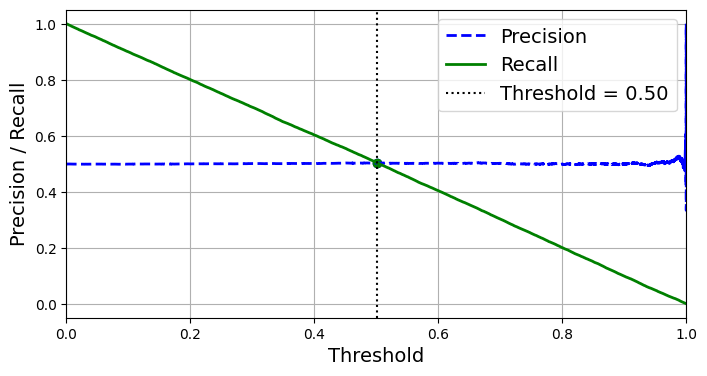

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Simulando dados
np.random.seed(42)
y_train_5 = np.random.randint(0, 2, size=(60000,))
y_scores = np.random.rand(60000)

# Calculando a curva de precisão-recall
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Plotando precisão e recall vs threshold
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

# Escolhendo um threshold razoável para marcar no gráfico
threshold_idx = len(thresholds) // 2  # Ponto intermediário
chosen_threshold = thresholds[threshold_idx]

# Destacando o threshold escolhido
plt.axvline(chosen_threshold, color="k", linestyle="dotted", label=f"Threshold = {chosen_threshold:.2f}")
plt.scatter(thresholds[threshold_idx], precisions[threshold_idx], color="blue", marker="o")
plt.scatter(thresholds[threshold_idx], recalls[threshold_idx], color="green", marker="o")

# Melhorando os eixos e legendas
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.legend(loc="best")
plt.grid(True)
plt.xlim(0, 1)  # Ajustando o eixo X para valores entre 0 e 1

# Exibir o gráfico
plt.show()


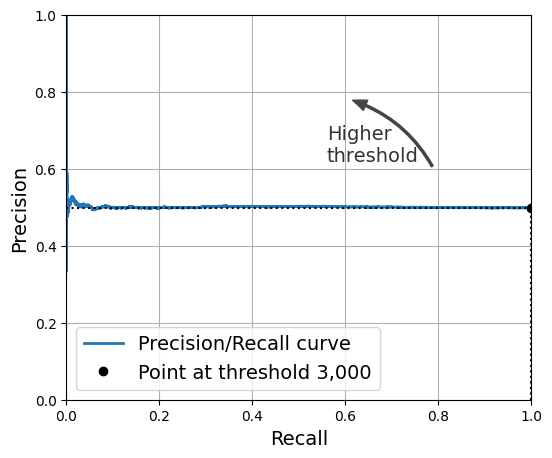

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(6, 5))  # extra code - for the curved arrow

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code - just beautifies and saves Figure
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))

plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

# Salvar o gráfico
plt.savefig("grafico.png", dpi=300)  # Salva o gráfico com boa qualidade

# Exibir o gráfico
plt.show()


In [27]:
idx_for_90_precision = np.argmax(precisions >= 0.90).argmax()
threshold_90_precision = thresholds[idx_for_90_precision]
threshold_90_precision

np.float64(5.536675737993768e-06)

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.4988666666666667

## The ROC Curve

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

In [30]:
threshold_for_90_precision = threshold_90_precision

Forma original de y_train_5: (60000,)
Forma original de y_scores: (60000, 1)
Forma corrigida de y_scores: (60000,)
Primeiros 5 valores de precisões: [0.49886667 0.49885831 0.49886663 0.49887494 0.49888326]
Primeiros 5 valores de recalls: [1.         0.99996659 0.99996659 0.99996659 0.99996659]
Primeiros 5 valores de thresholds: [5.53667574e-06 8.43221130e-06 1.67362579e-05 4.68697916e-05
 6.74976466e-05]


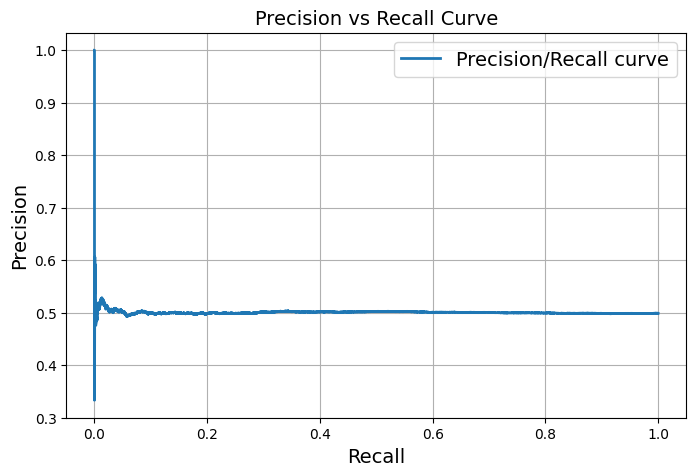

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Supondo que y_train_5 e y_scores já existam no seu código
# Aqui estão exemplos fictícios para demonstração
np.random.seed(42)
y_train_5 = np.random.randint(0, 2, size=(60000,))  # Array binário com 60000 elementos
y_scores = np.random.rand(60000, 1)  # Simulando scores com dimensão (60000, 1)

# Verificar as formas dos arrays
print("Forma original de y_train_5:", y_train_5.shape)
print("Forma original de y_scores:", y_scores.shape)

# Garantir que y_scores seja um array 1D
if y_scores.ndim == 2 and y_scores.shape[1] == 1:
    y_scores = y_scores.ravel()

# Verificar se os formatos agora são compatíveis
print("Forma corrigida de y_scores:", y_scores.shape)

# Aplicar precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Exibir alguns resultados
print("Primeiros 5 valores de precisões:", precisions[:5])
print("Primeiros 5 valores de recalls:", recalls[:5])
print("Primeiros 5 valores de thresholds:", thresholds[:5])

# **Plotando a curva Precision-Recall**
plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# Melhorando visualização
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall Curve")
plt.legend(loc="best")
plt.grid(True)

# **Salvar o gráfico como imagem**
plt.savefig("precision_recall_curve.png", dpi=300)  # Salva em alta resolução
plt.show()  # Exibe o gráfico


In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.5023493354036965)

In [33]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [34]:
# Achatar X_train para que cada imagem seja uma linha de 784 pixels
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Usar cross_val_predict com o RandomForestClassifier
y_probas_forest = cross_val_predict(forest_clf, X_train_flattened, y_train_5, cv=3, method="predict_proba")

In [35]:
y_probas_forest = cross_val_predict(forest_clf, X_train_flattened, y_train_5, cv=3, method="predict_proba")

In [36]:
y_probas_forest

array([[0.47, 0.53],
       [0.45, 0.55],
       [0.48, 0.52],
       ...,
       [0.53, 0.47],
       [0.51, 0.49],
       [0.64, 0.36]])

These are _estimated probabilities_. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:

In [37]:
# Not in the code
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

50.1%


In [38]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

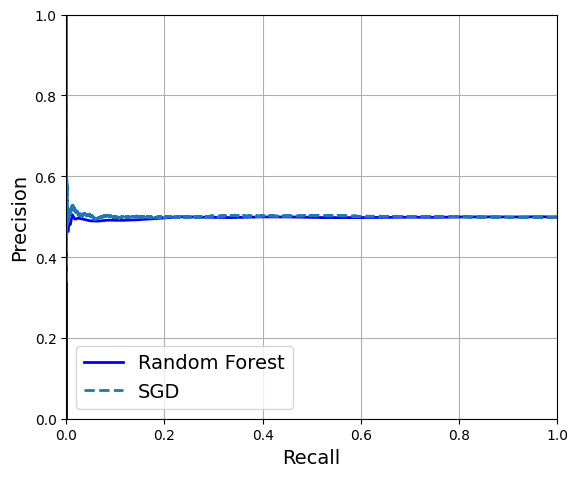

In [39]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

## Multiclasss Classification


In [40]:
print("Forma de X_train[:2000]:", X_train[:2000].shape)
print("Forma de y_train[:2000]:", y_train[:2000].shape)


Forma de X_train[:2000]: (2000, 28, 28)
Forma de y_train[:2000]: (2000,)


In [41]:
from sklearn.svm import SVC

# Achatar as imagens (2000, 28, 28) -> (2000, 784)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  

# Criar e treinar o modelo SVM



In [42]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_flat[:2000], y_train[:2000]) 

SVC(random_state=42)

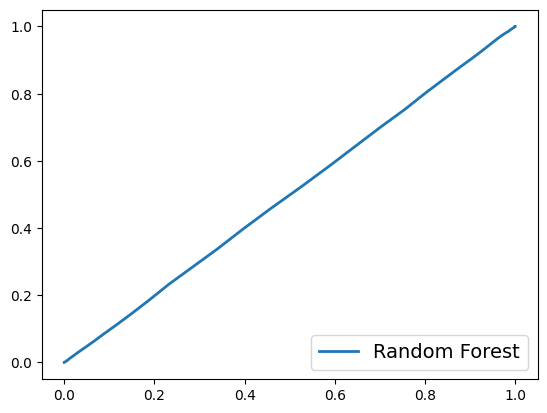

In [43]:
y_probas_forest = y_probas_forest[:, 1]
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, linewidth=2, label="Random Forest")
plt.legend(loc = 'lower right')
plt.show()

## Multiclass Classification
SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [44]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_flattened[:2000], y_train[:2000])

SVC(random_state=42)

In [45]:
svm_clf.predict([some_digit.flatten()])

array([5], dtype=uint8)

In [46]:
some_digit_scores = svm_clf.decision_function([some_digit.flatten()])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [47]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

If you want `decision_function()` to return all 45 scores, you can set the `decision_function_shape` hyperparameter to `"ovo"`. The default value is `"ovr"`, but don't let this confuse you: `SVC` always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [48]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit.flatten()])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [49]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train_flattened[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [50]:
ovr_clf.predict([some_digit.flatten()])

array([5], dtype=uint8)

In [51]:
len(ovr_clf.estimators_)

10

In [52]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_flat, y_train)
sgd_clf.predict([some_digit.flatten()])

array([3], dtype=uint8)

In [53]:
sgd_clf.decision_function([some_digit.flatten()]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [54]:
cross_val_score(sgd_clf, X_train_flat, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Análise de erro

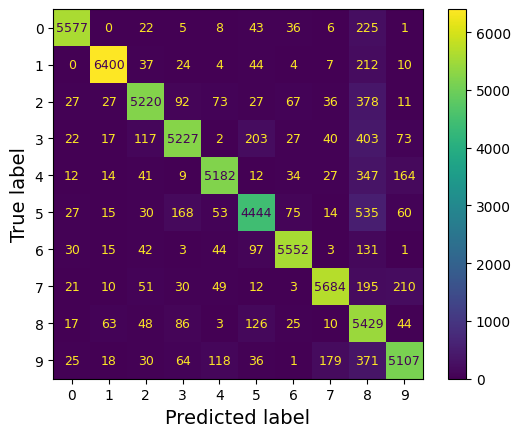

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()


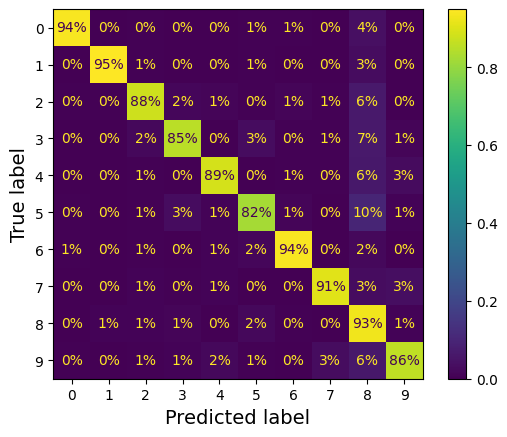

In [57]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

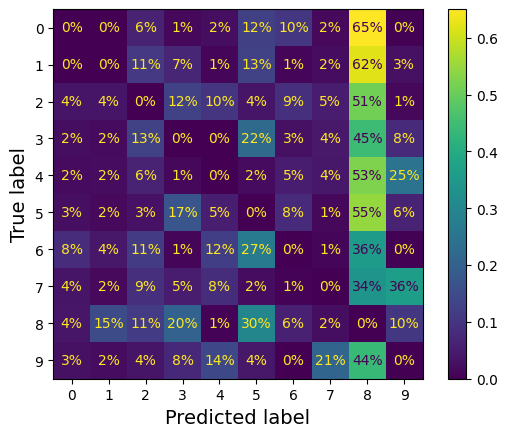

In [58]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

## Multilabel Classification

In [59]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train.astype(int) >= 7)
y_train_odd = (y_train.astype(int) % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_flat, y_multilabel)


KNeighborsClassifier()

In [60]:
knn_clf.predict([some_digit.flatten()])

array([[False,  True]])

In [61]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_flat, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [62]:
# extra code – shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

## Multioutput Classification

In [63]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

ValueError: operands could not be broadcast together with shapes (60000,28,28) (60000,784) 

In [ ]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()


## Building a spam classifier
* _Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello," "how," "are," "you," then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning [“Hello" is present, "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word._

In [2]:
import tarfile
import urllib.request
from pathlib import Path

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    # Especificar o caminho completo
    spam_path = Path("C:/Users/vish8/OneDrive/Desktop/Livro/Cap3-Classificação/datasets/spam")
    spam_path.mkdir(parents=True, exist_ok=True)
    
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            try:
                urllib.request.urlretrieve(url, path)
                tar_bz2_file = tarfile.open(path)
                tar_bz2_file.extractall(path=spam_path)
                tar_bz2_file.close()
                print(f"Downloaded and extracted {dir_name} successfully.")
            except Exception as e:
                print(f"Failed to download or extract {dir_name}: {e}")
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

# Chamar a função para testar
fetch_spam_data()

[WindowsPath('C:/Users/vish8/OneDrive/Desktop/Livro/Cap3-Classificação/datasets/spam/easy_ham'),
 WindowsPath('C:/Users/vish8/OneDrive/Desktop/Livro/Cap3-Classificação/datasets/spam/spam')]

In [3]:
ham_dir, spam_dir = fetch_spam_data()

In [4]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len (f.name) >20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len (f.name) >20]

In [5]:
len(ham_filenames), len(spam_filenames)

(2500, 500)

In [17]:
#We can use pythons email module to parse these emails

import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [18]:
ham_emails = [load_email(filename) for filename in ham_filenames]
spam_emails = [load_email(filename) for filename in spam_filenames]

In [19]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [20]:
#temos diferentes tipos de estrutura para os emails, alguns são multiparte, outros são apenas textos, outros são imagens, etc
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [21]:
from collections import Counter 

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [22]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [23]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [24]:
for headers, value in spam_emails[0].items():
    print(headers, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [25]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [26]:
#Lets start split the dataset s
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype = object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [27]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [28]:
html_spam_emails = [email for email in X_train[y_train == 1]
                    if get_email_structure(email) == "text/html"]

sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [29]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

## Now let's write a funciton that takes an email as input and returns its content as plain text ,whatever its format is:

In [30]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [31]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


#### Lets throw some stemming! We will use NLP (''NLTK'')

In [32]:
!pip install nltk

  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached regex-2024.11.6-cp310-cp310-win_amd64.whl.metadata (41 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.5 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.0 MB/s eta 0:00:00
Using cached regex-2024.11.6-cp310-cp310-win_amd64.whl (274 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import nltk
stemmer = nltk.PorterStemmer()
for word in (("Computations", "Computation", "Computing", "Computed",
              "Compulsive", "Compute")):
    print(word, "=>", stemmer.stem(word))


Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compulsive => compuls
Compute => comput


In [36]:
!pip install urlextract


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import urlextract # may require an Internet connection to download root domain
                  # names

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers = True, lower_case = True,
                 remove_punctuation = True, replace_url = True,
                 replace_numbers = True, stemming = True):